In [3]:
%matplotlib inline
import json
import pandas as pd

In [4]:
# Read and return the "api_key" key from a JSON file
def read_key(fn):
    with open(fn) as json_file:
        data = json.load(json_file)
        return data["api_key"]

# Using Data APIs in Python to Improve Urban Life



## Obtaining US Census Data Through Python Packages

Every 10 years the US conducts a national census. The data collected are extensisve and are aggregated spatially in areas called census tracts. There is a python package for accessing the data through the [APIs served by the Census Bureau](http://www.census.gov/developers/).

This package requires you to know a fair amount about how census data is structured and what the various attributes are called. For an example, we'll look at the American Community Survey 5-year data (refered to as [acs5](http://www.census.gov/data/developers/data-sets/acs-5year.html)) and some of the variables related to povery measures including [total population](http://api.census.gov/data/2014/acs5/variables/B01003_001E.json), and [population below the povery level by work experiance](http://api.census.gov/data/2014/acs5/variables/B17009_002E.json).

The Census Bureau's API requires an API key to be able to access it. This is a unique string that is assiged to you so that your API use can be tracked and rate limited if needed. Some data API providers charge money for use of their APIs and keys let them bill the right person. The Python package will pass along your API key to the Census servers.

You can get a free [Census Bureau API key here](http://api.census.gov/data/key_signup.html).

API keys are secrets that should not be made public, like a password. Be careful about putting API keys into your code, especially if you commit it to a public code repository like Github. Remember, once you have commited an API key to a version control system, it is there forever. You must cancel your old key and get a new one immediately.

One pattern for managing API keys is to put them in a separate file which is excluded from verison control and read them into your code.

In [6]:
census_api_key = read_key("census.key")
print(census_api_key[0:10])

d91de1bcda


Now that we have a key loaded, let's get a couple parameters from the census by census tract for Alachua county. The census uses [FIPS codes](https://en.wikipedia.org/wiki/FIPS_county_code) to tell what state and county data is in.

In [10]:
# Before running you will need to install the 'census' package with
# pip install census
from census import Census

florida_fips = '12'
alachua_fips = '001'

census_api = Census(census_api_key)
census_data = census_api.acs5.state_county_tract(
    ('NAME', 'B01003_001E', 'B14006_002E', 'B17009_002E'), 
    florida_fips, alachua_fips, Census.ALL)

census_data[0:2]

[{u'B01003_001E': u'7545',
  u'B14006_002E': u'4353',
  u'B17009_002E': u'4089',
  u'NAME': u'Census Tract 2, Alachua County, Florida',
  u'county': u'001',
  u'state': u'12',
  u'tract': u'000200'},
 {u'B01003_001E': u'3401',
  u'B14006_002E': u'1429',
  u'B17009_002E': u'1061',
  u'NAME': u'Census Tract 3.01, Alachua County, Florida',
  u'county': u'001',
  u'state': u'12',
  u'tract': u'000301'}]

What did we get back? This is a list of dictionaries. This is a common representation of data and when we talk about JSON in a few minutes you'll see why data APIs and libraries that work with them like this format.

This is such a common structure that Pandas includes a function to convert it directly to a data frame:

In [11]:
poverty_by_tract = pd.DataFrame.from_dict(census_data)
poverty_by_tract.describe()

,B01003_001E,B14006_002E,B17009_002E,NAME,county,state,tract
count,56,56,56,56,56,56,56
unique,56,55,55,56,1,1,56
top,822,1477,222,"Census Tract 22.07, Alachua County, Florida",001,12,001907
freq,1,2,2,1,56,56,1


Now let's calculate the percentage of the population living in poverty in each census tract. To do that we'll divide the total number living below the poverty line by the total population and put it in a new column of the dataframe. Because our data was returned as strings, we need to convert each one to a float before dividing.

In [16]:
poverty_by_tract['percent'] = poverty_by_tract.apply(
    lambda row: float(row['B17009_002E']) / float(row['B14006_002E']), axis=1)

poverty_by_tract.describe()

,percent
count,56.000000
mean,0.555206
std,0.266553
min,0.000000
25%,0.323790
50%,0.532289
75%,0.774906
max,1.000000


You can see that the calls to the census package and even the data formating are just a few lines of code however you still need to know quite a lot about how census data is represented in order to use the Python package. Desciptive data about data are called "metadata". You can find the metadata for some of what we have used above at the Census Bureau.

### Mapping Poverty by Census Tract on Top of Basemap Data Layers

#### Downloading Census Tract Layer

In [6]:
# pip install https://github.com/matplotlib/basemap/archive/v1.0.7rel.tar.gz
# This is 130 MB, needed geos, numpy, matplotlib, pandas first, also apt install libgeos-dev
# or apt install python-mpltoolkits.basemap python-mpltoolkits.basemap-data

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

#### Drawing a Map of Census Tracts

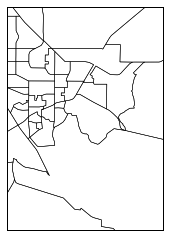

In [34]:
my_map = Basemap(llcrnrlon=-82.4,llcrnrlat=29.5,urcrnrlon=-82.2,urcrnrlat=29.75,
             resolution='i', projection='tmerc', lat_0 = 29.65, lon_0 = -82.33)
#Basemap(projection='ortho', lat_0=29.65, lon_0=-82.32,
#              llcrnrlon=-0.5,llcrnrlat=39.8,urcrnrlon=4.,urcrnrlat=43.,
#              resolution='l', area_thresh=1000.0)
 
my_map.drawcoastlines()
my_map.readshapefile("data/gz_2010_12_140_00_500k", "census_tracts")
#my_map.readshapefile("data/county_roads", "counties")
 
plt.show()

## Does Having Natural Gas Service Save Money?

### Obtaining Gaineville Regional Utilities (GRU) Billing Data Through Socrata's API from data.cityofgainesville.org

In [36]:
data_set_id = "gk3k-9435"
year = "2016"
api_url = ("https://data.cityofgainesville.org/resource/{0}.json?year={1}&month=January"
    .format(data_set_id, year))
gru_data = pd.read_json(api_url)

In [37]:
gru_data.count()

date               1000
kwh_consumption    1000
location_1         1000
month              1000
servcity           1000
serviceaddress     1000
year               1000
dtype: int64

### Calculating Savings

### Obtaining Property Appraiser Data Through Manual Downloads from www.acpafl.org

In [8]:
appraiser_data = pd.read_csv("data/32605_00100_50k_100k.csv")
appraiser_data.head()

,Parcel_Num,Owner_Mail_Name,Owner_Mail_CO,Owner_Mail_Addr1,Owner_Mail_Addr2,Owner_Mail_City,Owner_Mail_State,Owner_Mail_Zip,Section,Township,...,School_Exempt_Amount,Tax_Amount,Loc_Address,Sale_Date,Sale_Price,Sale_VacImp,Sale_Qualified,Sale_Book,Sale_Page,Sale_Instrument
0,00450-000-000,"WARD, JODI",NaN,1236 NW 39TH DR,NaN,GAINESVILLE,FL,32605-4647,2,8,...,0,1728.82,18743 NW 230TH ST,05/10/2011,100,I,U,4031,449,WD
1,00528-000-000,"DIRK, LYNN M",NaN,1604 NW 21ST AVE,NaN,GAINESVILLE,FL,32605-4062,34,7,...,0,1286.20,23674 NW 188TH AV,02/15/2006,100,I,U,3317,820,OD
2,01408-113-000,"MILLER, GREGORY A & KAREN L",NaN,PO BOX 2693,NaN,HIGH SPRINGS,FL,32655-2693,3,8,...,2610,1621.35,17521 NW 239TH TER,05/27/1994,42500,I,Q,1970,562,WD
3,01981-012-004,"BOGART, JOSEPH W",NaN,4022 NW 36TH ST,NaN,GAINESVILLE,FL,32605-1445,4,10,...,0,1687.81,26442 SW 4TH AV,02/18/2008,81000,I,U,3745,220,CT
4,02534-001-011,"MITCHELL, LAURIE DUKES TRUSTEE",NaN,7818 NW 22ND LN,NaN,GAINESVILLE,FL,32605,9,10,...,120,2278.50,25306 SW 16TH AV,09/23/2008,65000,I,U,3831,1398,WD


### Graphing Single Family Residence Savings by Square Footage

## Which Homes Should We Help Convert to Natural Gas?


### Geocoding Residences with Google's Service With the geocoder Package 

In [9]:
with open('google.key') as json_file:
    data = json.load(json_file)
google_api_key = data["api_key"]

In [10]:
import geocoder
g = geocoder.google("1604 NW 21ST AVE GAINESVILLE FL 32605-4062", 
                    key=google_api_key)
g.json

{'accuracy': u'ROOFTOP',
 'address': u'1604 NW 21 Ave, Gainesville, FL 32605, USA',
 'bbox': {'northeast': [29.6736079802915, -82.3409870197085],
  'southwest': [29.6709100197085, -82.34368498029151]},
 'city': u'Gainesville',
 'confidence': 9,
 'country': u'US',
 'county': u'Alachua County',
 'encoding': 'utf-8',
 'housenumber': u'1604',
 'lat': 29.672259,
 'lng': -82.342336,
 'location': '1604 NW 21ST AVE GAINESVILLE FL 32605-4062',
 'ok': True,
 'place': u'ChIJJQ6ZKWOk6IgRTTtpZvrFbxA',
 'postal': u'32605',
 'provider': 'google',
 'quality': u'street_address',
 'state': u'FL',
 'status': 'OK',
 'status_code': 200,
 'street': u'NW 21 Ave'}

### Adding Residences Without Gas Service to the Map